# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [1]:
%run __init__.py

INFO:root:Starting logger


In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [3]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [4]:
from herc_common.text import TextPreprocessor

The following function will be used to show the top terms of each topic extracted by a given model:

In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [6]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=10):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [7]:
MIN_TOPICS = 3
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [8]:
from herc_common.utils import save_object

Now that we have defined our common set of functions, we can start working on each dataset.

## Agriculture

### Loading the dataframe

In [9]:
DF_FILE_PATH = os.path.join(NOTEBOOK_2_RESULTS_DIR, 'protocols_dataframe.pkl')

df = pd.read_pickle(DF_FILE_PATH)

### Preprocessing text

In [10]:
protocols = df['full_text_cleaned'].values

In [11]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_lg

custom_stop_words = {"introduction", "fig", "figure", "figures" "figs", "min", "add", "remove", "sample"}

preprocessor = TextPreprocessor(en_core_sci_lg, custom_stop_words)
preprocessed_texts = preprocessor.fit_transform(protocols)

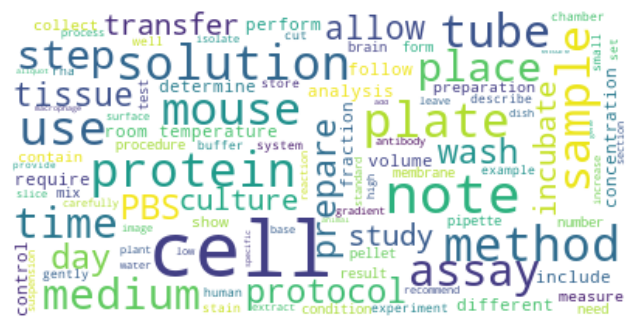

In [12]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [14]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func,
                         topic_word_prior=0.1)
lda_results

c:\users\alex\.envs\edma\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7475 unique tokens: ['scratch', 'Wound', 'healing', 'assay', 'wound']...) from 100 documents (total 62597 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7475 unique tokens: ['scratch', 'Wound', 'healing', 'assay', 'wound']...) from 100 documents (total 62597 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7475 unique tokens: ['scratch', 'Wound', 'healing', 'assay', 'wound']...) from 100 documents (total 62597 corpus 

{LatentDirichletAllocation(n_components=3, random_state=42, topic_word_prior=0.1): -0.9071932438737306,
 LatentDirichletAllocation(n_components=4, random_state=42, topic_word_prior=0.1): -1.3783217593244557,
 LatentDirichletAllocation(n_components=5, random_state=42, topic_word_prior=0.1): -3.816485521015173,
 LatentDirichletAllocation(n_components=6, random_state=42, topic_word_prior=0.1): -2.8907229583286718,
 LatentDirichletAllocation(n_components=7, random_state=42, topic_word_prior=0.1): -3.579825466169719,
 LatentDirichletAllocation(n_components=8, random_state=42, topic_word_prior=0.1): -3.314763560813037,
 LatentDirichletAllocation(n_components=9, random_state=42, topic_word_prior=0.1): -2.699085512892007,
 LatentDirichletAllocation(random_state=42, topic_word_prior=0.1): -2.860220437788324,
 LatentDirichletAllocation(n_components=11, random_state=42,
                           topic_word_prior=0.1): -1.8139745761506452,
 LatentDirichletAllocation(n_components=12, random_state=

In [15]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': 0.1, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -0.9071932438737306


Visualization. Do this with the best model obtained before.

In [16]:
best_lda_model = LatentDirichletAllocation(n_components=11, topic_word_prior=0.2, random_state=RANDOM_SEED)
best_lda_model.fit(dtm_tf)

LatentDirichletAllocation(n_components=11, random_state=42,
                          topic_word_prior=0.2)

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: sample tissue activity specimen nematode image method solution protocol section
Topic #1: cell medium plate day wash dish tube culture time note
Topic #2: protein fraction tube buffer cell membrane gradient pellet note use
Topic #3: gene sequence soybean homologous common bean syntenic tumorsphere genome alignment
Topic #4: optiprep cell pathological cushion tube tissue brain assay homogenate ftld
Topic #5: slice chamber mouse micropump acsf control interface synaptic brain circuit
Topic #6: fiber mouse odor food implant optic ubiquitylation skull behavior place
Topic #7: protein tumor metabolite standard sample tube antibody cell fluid primer
Topic #8: cell medium solution tube culture macrophage incubate embryo note PBS
Topic #9: cell tube medium tissue centrifuge solution supernatant liver mouse pellet
Topic #10: plate tube plant solution root mutation medium culture colony cell



In [18]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      158.304245  152.859161       1        1  20.764980
10    -154.908630  -15.818744       2        1  13.927217
8     -213.980865  376.240234       3        1  12.121102
2      378.758820 -486.598969       4        1  10.941884
9     -381.861908 -316.007904       5        1  10.037518
5      148.385742  530.916138       6        1   9.994880
7      -51.129013 -527.202759       7        1   8.628529
0      137.890610 -201.229828       8        1   7.391475
6     -511.841278   96.375031       9        1   3.117230
4      509.044678  293.871857      10        1   1.630579
3      518.291443  -99.628937      11        1   1.444605, topic_info=          Term         Freq        Total Category  logprob  loglift
2231      cell  1189.000000  1189.000000  Default  30.0000  30.0000
5812   protein   307.000000   307.000000  Default  29.0000  29.0000
3721      gene    83.000000    83.000000  Default  28.0000  28.0000
6453     slice    96.000000    96.000000  Default  27.0000  27.0000
3643  fraction   122.000000   122.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
6986      time     2.344236   227.570427  Topic11  -5.9552  -0.3382
4879    modify     1.966134    30.268933  Topic11  -6.1311   1.5033
2429   compare     1.966134    23.866147  Topic11  -6.1311   1.7409
4962    muscle     1.966134    47.908381  Topic11  -6.1311   1.0441
1707  analysis     1.966133   109.795239  Topic11  -6.1311   0.2148

[716 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
29       10  0.418920       Air
42       11  0.427827  Altschul
46        2  0.910256      Ames
56        9  0.609828     Angle
67        6  0.919335   Arduino
...     ...       ...       ...
7445      4  0.691795     yeast
7445      7  0.053215     yeast
7447      3  0.883217       yes
7461      6  0.886882       zip
7467      3  0.888478    zygote

[1824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 9, 3, 10, 6, 8, 1, 7, 5, 4])

In [19]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_protocols_pipe_filename = "protocols_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_protocols_pipe_filename))

In [20]:
dtm_tf_filename = "protocols_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tf_filename))

#### LDA with bigrams

In [ ]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

In [ ]:
# best_bigram_lda_model = get_best_model(bigram_lda_results)
best_bigram_lda_model = LatentDirichletAllocation(n_components=12)
best_bigram_lda_model.fit_transform(bigram_dtm_tf)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

In [ ]:
bigram_lda_pipeline = Pipeline([('preprocessing', preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

### Latent Semantic Analysis (LSA)

In [ ]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

In [ ]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

In [ ]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lsa_agriculture_pipe_filename))

### NMF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [ ]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=900)
nmf_results

In [ ]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

In [ ]:
best_nmf_model = NMF(n_components=29, max_iter=400, random_state=RANDOM_SEED)
best_nmf_model.fit(dtm_tfidf)

In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

In [ ]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, nmf_agriculture_pipe_filename))

In [ ]:
dtm_tfidf_filename = "agriculture_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tfidf_filename))